## Variable Selection

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# select item (use item 2 if it switched model numbers but is same item)
item = '4100'
item2 = None

store_count_change = 15 # percentage increase in store count
growth_rate = 1 + (store_count_change / 100) # converts to a percentage

# this changes the length dropped off for the benchmarks
forecast_length = 4

# this changes the array in the pycaret if you do the arange it will do a point forecast at the future time
forecast_lenth_array = np.arange(forecast_length, forecast_length+1)
#forecast_lenth_array = forecast_length

## Data

In [88]:
df = pd.read_csv('Items Shipped by Item by Month.csv')

In [89]:
df.head()

,Date,Item,Item Description,Product Group,Parent Product Group,Quantity,Amount
0,2024-Oct,8003,E-Series 22in Electric Tabletop Griddle w/Cart...,E-Griddles,Cooking Unit,120.0,17404.80
1,2024-Oct,1868,"36"" Griddle AirFryer",Griddles,Cooking Unit,72.0,21793.16
2,2024-Oct,1785,"28"" AirFryer Combo",Griddles,Cooking Unit,42.0,9032.56
3,2024-Oct,2379,Tabletop Pizza Oven-Walmart 2024,Pizza Oven,Cooking Unit,1404.0,122360.56
4,2024-Oct,2379,Tabletop Pizza Oven-Walmart 2024,Pizza Oven,Cooking Unit,3544.0,308864.56


## Data Formatting

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33899 entries, 0 to 33898
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  33899 non-null  object 
 1   Item                  33899 non-null  object 
 2   Item Description      33748 non-null  object 
 3   Product Group         33640 non-null  object 
 4   Parent Product Group  33899 non-null  object 
 5   Quantity              33883 non-null  float64
 6   Amount                33899 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.8+ MB


In [94]:
df['Date'] = pd.to_datetime(df['Date'])

if item2:
    df_item = df[(df['Item'] == item) | (df['Item'] == item2)]
else:
    df_item = df[df['Item'] == item]

df_item = df_item.groupby(['Date'])['Quantity'].sum().reset_index().sort_values(by='Date', ascending=True)

df_item = df_item.resample('M', on='Date').sum().reset_index()
#df_item = df_item[:-1] # drop the last month if in middle of month
#df_item['Quantity'] = df_item['Quantity'] * growth_rate

df_item.tail(1)

,Date,Quantity
56,2024-09-30,8034.0


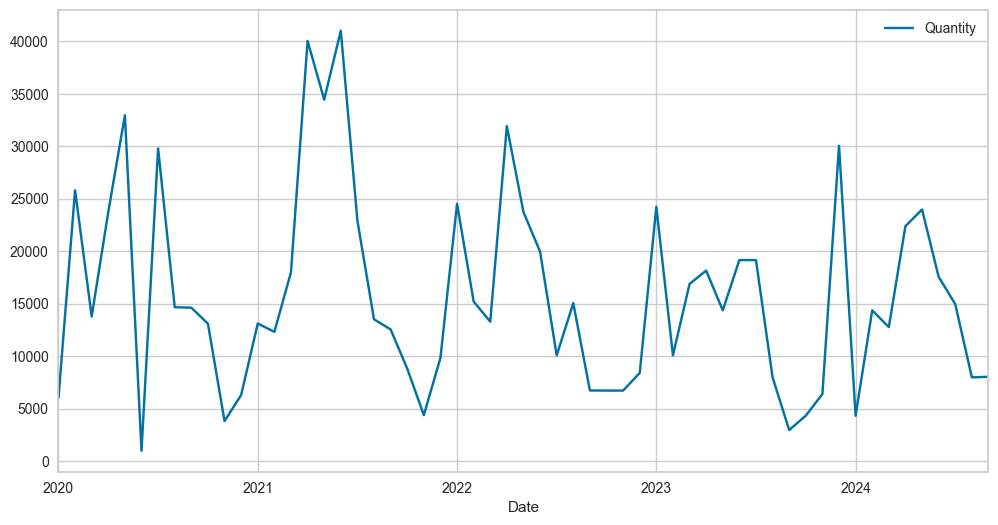

In [61]:
# Plot the time series data
df_item.plot(x='Date', y='Quantity', figsize=(12,6))
unchanged_df = df_item.copy()

## Data Transformation

### Box Cox Transformation

In [62]:
from scipy.stats import boxcox

        Date  Quantity  boxcox_units
0 2020-01-31    6030.0     84.465211
1 2020-02-29   25806.0    155.446353
2 2020-03-31   13776.0    119.570158
3 2020-04-30   23736.0    150.116839
4 2020-05-31   32946.0    172.106012
The optimal lambda for Box-Cox transformation is: 0.41068857463232916


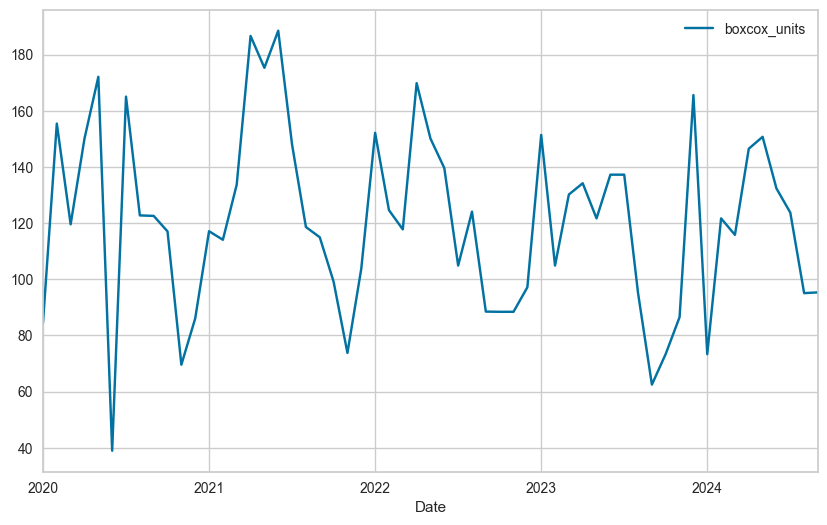

In [63]:
# Apply Box-Cox transformation to find the optimal lambda
try:
    df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)
except ValueError: 
    df_item['Quantity'] = df_item['Quantity'] + 1
    df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)

print(df_item.head())
box_cox_df = df_item.copy()

# Plot the transformed data with optimal lambda
df_item.plot(x='Date', y='boxcox_units', figsize=(10,6))

# Print the optimal lambda
print(f'The optimal lambda for Box-Cox transformation is: {optimal_lambda}')

### ACF and PACF

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

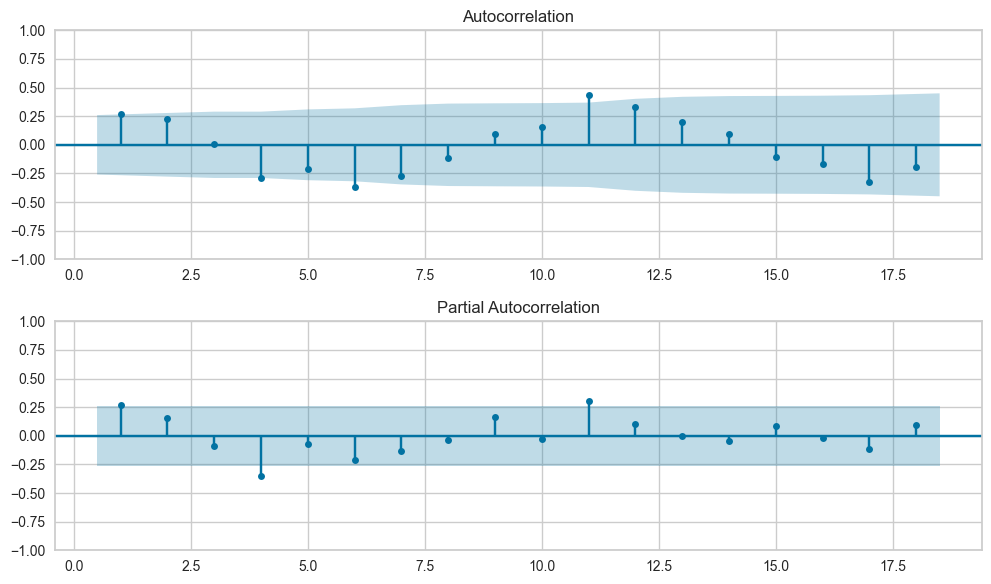

In [65]:
# Plot ACF and PACF for the original airline passenger data
plt.figure(figsize=(10, 6))
plt.subplot(211)
plot_acf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.subplot(212)
plot_pacf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.tight_layout()
plt.show()

### Stationarity

In [66]:
from statsmodels.tsa.stattools import adfuller

Augmented Dickey-Fuller Test: Box-Cox Data
ADF Test Statistic            -5.958227e+00
p-value                        2.068657e-07
# Lags Used                    0.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
=> The series is stationary.


<Axes: xlabel='Date'>

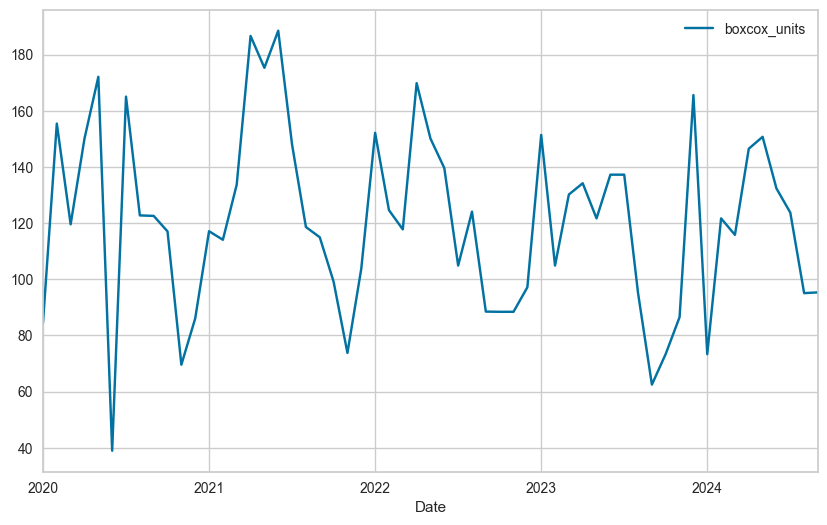

In [67]:
# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")
    return result[1]

# Apply the ADF test to the transformed data
p_value = adf_test(df_item['boxcox_units'], title='Box-Cox Data')

df_item.plot(x='Date',y='boxcox_units', figsize=(10,6))

#### Differencing Data

Augmented Dickey-Fuller Test: boxcox quantity- Differenced
ADF Test Statistic            -6.022692e+00
p-value                        1.480762e-07
# Lags Used                    9.000000e+00
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
=> The series is stationary.


<Axes: xlabel='Date'>

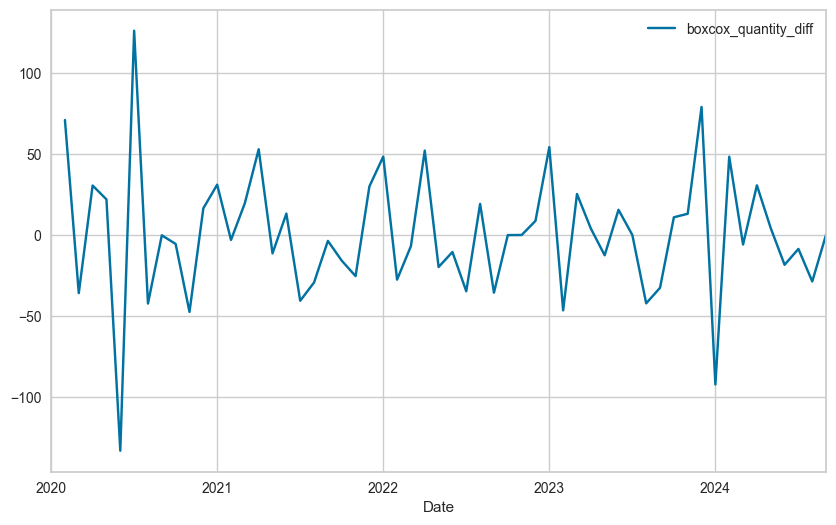

In [68]:
# differencing the data
df_item['boxcox_quantity_diff'] = df_item['boxcox_units'].diff()

# Perform ADF test on differenced data
adf_test(df_item['boxcox_quantity_diff'].dropna(), title='boxcox quantity- Differenced')

# Plot the differenced data
df_item.plot(x='Date', y='boxcox_quantity_diff', figsize=(10,6))

## Benchmarking

#### Multi-Horizon Benchmark

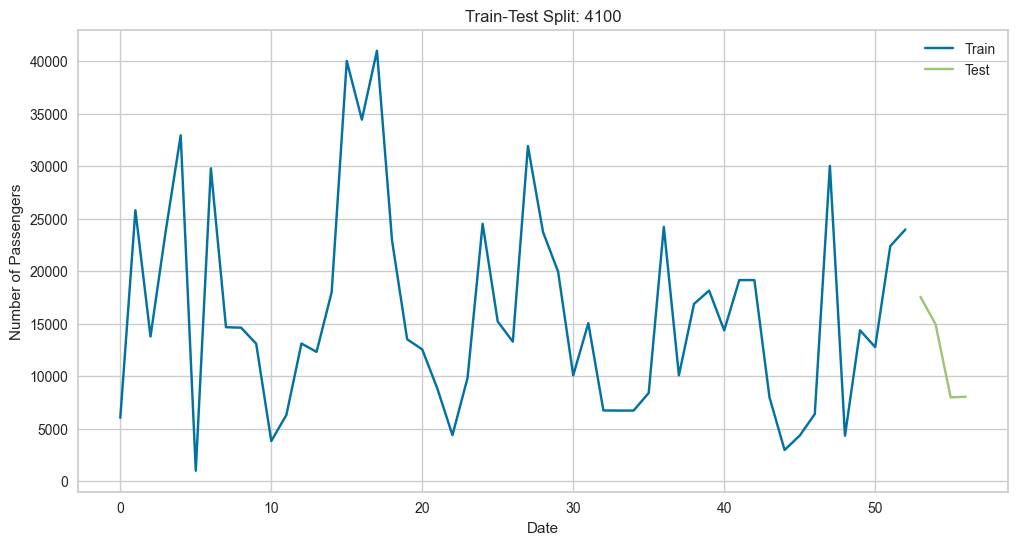

In [69]:
# Split the data
train = df_item[['Quantity']][:-forecast_length]
test = df_item[['Quantity']][-forecast_length:]

# Visualize the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title(f'Train-Test Split: {item}')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

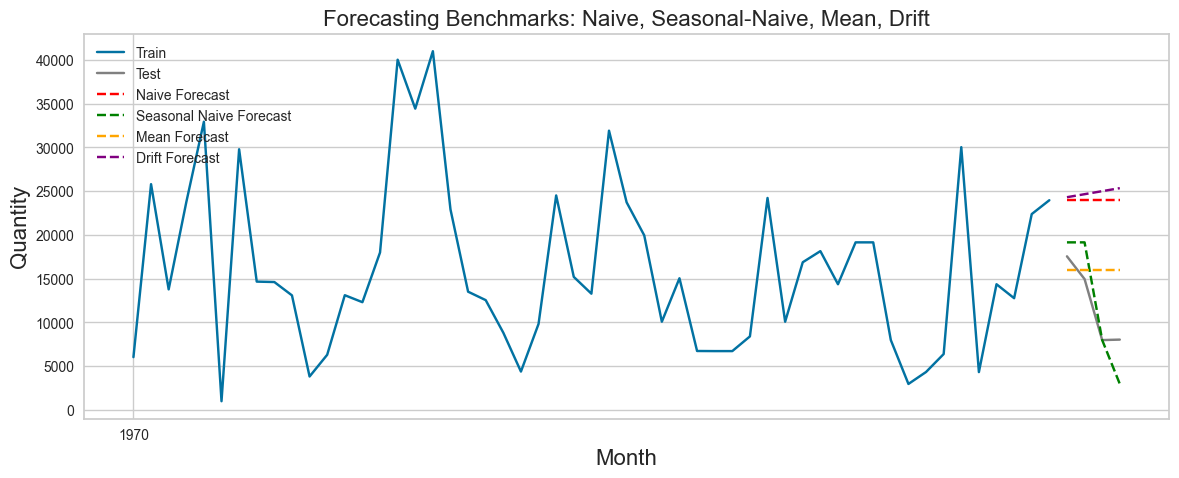

In [70]:
# Naive Forecast
# The naive forecaster simply uses the last observation from the training set
# as the forecast for all future observations.
y_hat_naive = test.copy()
y_hat_naive['naive'] = train.iloc[-1]['Quantity']

# Seasonal Naive Forecast:
# The seasonal naive forecaster uses the observation 
# from the same season of the previous cycle as the forecast.
season_length = 12
train_values_for_snaive = train['Quantity'].values[-season_length:]  # Last season's data
y_hat_snaive = test.copy()
y_hat_snaive['snaive'] = np.tile(train_values_for_snaive, len(test)//season_length+1)[:len(test)]

# Mean Forecast:
# The mean forecaster uses the mean of the training set as the forecast for all future observations.
y_hat_mean = test.copy()
y_hat_mean['mean'] = train['Quantity'].mean()

# Drift Forecast:
# The drift forecaster extrapolates a line between the first and last observations
# in the training set.
y_hat_drift = test.copy()
num_periods = len(train) - 1
drift = (train['Quantity'].iloc[-1] - train['Quantity'].iloc[0]) / num_periods
y_hat_drift['drift'] = [train['Quantity'].iloc[-1] + (i+1) * drift for i in range(len(test))]


# Ensure index types are correct
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
y_hat_naive.index = pd.to_datetime(y_hat_naive.index)
y_hat_snaive.index = pd.to_datetime(y_hat_snaive.index)
y_hat_mean.index = pd.to_datetime(y_hat_mean.index)
y_hat_drift.index = pd.to_datetime(y_hat_drift.index)

# Visualization
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')
plt.plot(y_hat_naive.index, y_hat_naive['naive'], label='Naive Forecast', color='red', linestyle='--')
plt.plot(y_hat_snaive.index, y_hat_snaive['snaive'], label='Seasonal Naive Forecast', color='green', linestyle='--')
plt.plot(y_hat_mean.index, y_hat_mean['mean'], label='Mean Forecast', color='orange', linestyle='--')
plt.plot(y_hat_drift.index, y_hat_drift['drift'], label='Drift Forecast', color='purple', linestyle='--')

plt.title('Forecasting Benchmarks: Naive, Seasonal-Naive, Mean, Drift', fontsize=16)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

#### One Step ahead benchmark

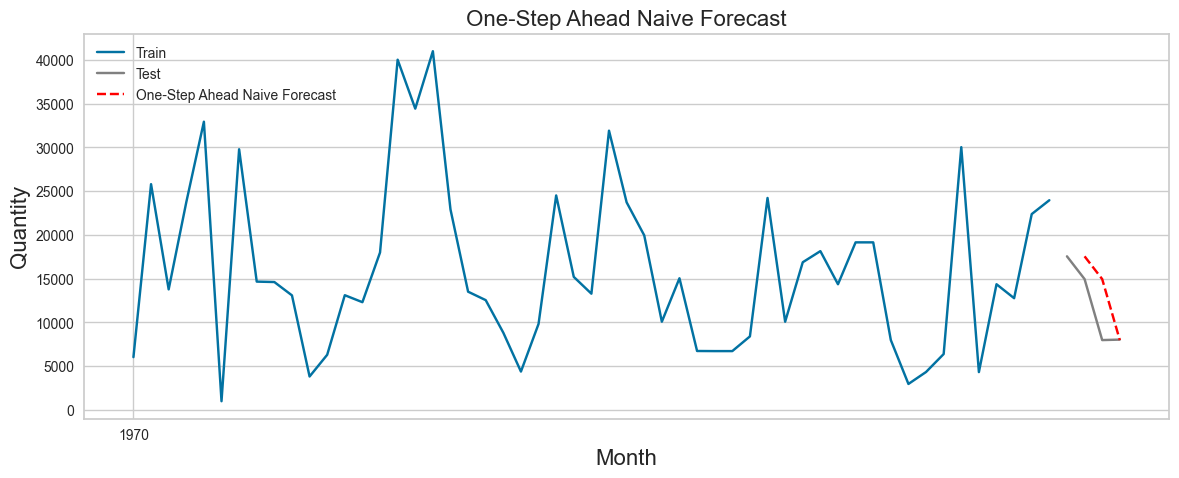

In [71]:
# Correcting the Naive Forecast for a true one-step ahead visualization
y_hat_naive_corrected = df_item.copy()
y_hat_naive_corrected['naive_one_step'] = df_item['Quantity'].shift(1)

# Adjusting visualization to focus on one-step ahead naive forecast in the test set
plt.figure(figsize=(14, 5))

# Original data (Train and Test)
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')

# One-step ahead naive forecast (Test set only)
# Shifting the test data one step for the naive forecast
test_shifted_for_naive = test['Quantity'].shift(1)
plt.plot(test.index, test_shifted_for_naive, label='One-Step Ahead Naive Forecast', color='red', linestyle='--')

plt.title('One-Step Ahead Naive Forecast', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

## Pycaret Forecast

In [72]:
from pycaret.time_series import *

In [73]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  57 non-null     datetime64[ns]
 1   Quantity              57 non-null     float64       
 2   boxcox_units          57 non-null     float64       
 3   boxcox_quantity_diff  56 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 KB


In [74]:
df_item = df_item.set_index('Date')
df_item.tail()

,Quantity,boxcox_units,boxcox_quantity_diff
Date,,,
2024-05-31,23970.0,150.732698,4.240775
2024-06-30,17556.0,132.344759,-18.387939
2024-07-31,14952.0,123.744529,-8.600230
2024-08-31,7980.0,95.062993,-28.681537
2024-09-30,8034.0,95.333410,0.270418


In [75]:
# if stationary use boxcox_units if not stationary use boxcox_quantity_diff
if p_value < 0.05:
    target = 'boxcox_units'
    drop_column = 'boxcox_quantity_diff'
else:
    target = 'boxcox_quantity_diff'
    drop_column = 'boxcox_units'

df_item = df_item.drop(columns=[drop_column,'Quantity'])
df_item.tail()

,boxcox_units
Date,
2024-05-31,150.732698
2024-06-30,132.344759
2024-07-31,123.744529
2024-08-31,95.062993
2024-09-30,95.333410


#### Setting up experiment

In [76]:
exp = TSForecastingExperiment()
exp.setup(data = df_item, 
          target=target,
          numeric_imputation_target='ffill',
          fh=forecast_lenth_array)

,Description,Value
0,session_id,2786
1,Target,boxcox_units
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(57, 1)"
5,Transformed data shape,"(57, 1)"
6,Transformed train set shape,"(53, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### Checking Set Up

In [77]:
exp.plot_model(plot='train_test_split')

In [78]:
#### Check cross-validation setup  ----
exp.plot_model(plot="cv")

### Comparing Models

In [79]:
best = exp.compare_models(sort='rmse')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
snaive,Seasonal Naive Forecaster,0.8269,0.5711,18.8905,18.8905,0.1392,0.1419,0.0433
arima,ARIMA,0.8588,0.5934,19.6160,19.6160,0.1425,0.1476,0.0500
auto_arima,Auto ARIMA,0.8713,0.6028,19.9020,19.9020,0.1407,0.1496,0.7333
grand_means,Grand Means Forecaster,0.8773,0.6079,20.0443,20.0443,0.1376,0.1503,0.0333
stlf,STLF,0.9131,0.6321,20.8730,20.8730,0.1482,0.1568,0.8500
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0365,0.7149,23.7103,23.7103,0.1852,0.1732,0.0933
croston,Croston,1.1819,0.8189,27.0099,27.0099,0.1864,0.2105,0.8367
polytrend,Polynomial Trend Forecaster,1.2611,0.8737,28.8181,28.8181,0.1993,0.2267,0.0300
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.3169,0.9108,30.1512,30.1512,0.2258,0.2240,0.1600
theta,Theta Forecaster,1.3274,0.9189,30.3887,30.3887,0.2227,0.2306,1.3167


#### Tune Model

In [80]:
try:
    tuned = exp.tune_model(best)
except ValueError:
    print("Could Not Tune")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-11,0.8008,0.5513,18.3776,18.3776,0.1587,0.1470
1,2023-12,1.0923,0.7526,24.8094,24.8094,0.1694,0.1850
2,2024-01,0.5877,0.4095,13.4846,13.4846,0.0895,0.0936
Mean,NaT,0.8269,0.5711,18.8905,18.8905,0.1392,0.1419
SD,NaT,0.2068,0.1408,4.6375,4.6375,0.0354,0.0375


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished


#### Finalizing Model

In [81]:
try:
    final = exp.finalize_model(tuned)
except NameError:
    final = exp.finalize_model(best)

In [82]:
exp.plot_model(final, plot='forecast', data_kwargs={'fh':forecast_lenth_array})

In [83]:
unseen_predictions = exp.predict_model(final, fh=forecast_lenth_array)
#unseen_predictions = exp.predict_model(final, fh=forecast_lenth_array, X=prediction_df)
unseen_predictions

,y_pred
2025-01,121.6825


## Reversing Transformation

In [84]:
from scipy.special import inv_boxcox

last_original_value = box_cox_df['boxcox_units'].iloc[-1]

# Reverse differencing (undo stationarity) if we applied it
if p_value < 0.05:
    reversed_diff_predictions = unseen_predictions
else:
    reversed_diff_predictions = unseen_predictions.cumsum() + last_original_value

# lambda value for Box-Cox transformation
boxcox_lambda = optimal_lambda

# Reverse Box-Cox transformation
original_scale_predictions = inv_boxcox(reversed_diff_predictions, boxcox_lambda)
#original_scale_predictions['y_pred'] = original_scale_predictions['y_pred'] * growth_rate

In [85]:
# making it so we can plot the forecast
unchanged_df.index = unchanged_df['Date']
unchanged_df = unchanged_df.drop(columns = ['Date'])

### Visualizing Prediction

               y_pred
2025-01  14363.992435


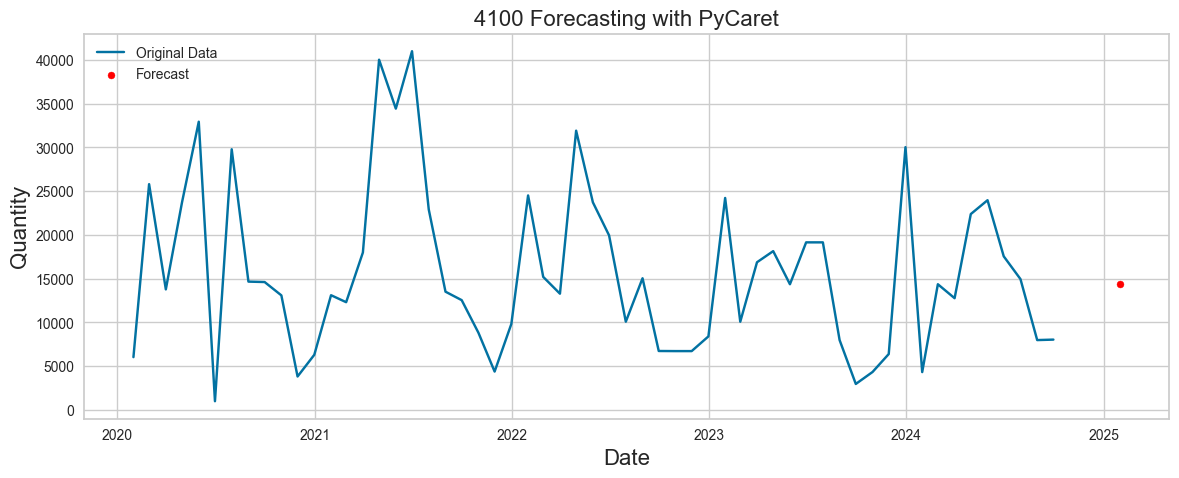

In [86]:
# viewing forecast quantity
print(original_scale_predictions)

# plotting forecast with original data
plt.figure(figsize=(14, 5))
plt.plot(unchanged_df.index, unchanged_df['Quantity'], label='Original Data')
plt.scatter(original_scale_predictions.index, original_scale_predictions, color='red', label='Forecast', s=25)
plt.title(f'{item} Forecasting with PyCaret', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.legend(loc='upper left')
plt.show()